In [7]:
# LSST stack imports
# from lsst.analysis.ap import apdb
from lsst.daf.butler import Butler

repo = "/repo/main"
collection = "LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478"
instrument = "LSSTComCam"

# afwDisplay.setDefaultBackend('firefly')
# display1 = afwDisplay.Display(frame=1)
# display1.getClient().get_firefly_url()

butler = Butler(repo, collections=collection)

In [10]:
visit_id = 2024110800302
detector_id = 0
ra, dec = 53.133445, -28.235972

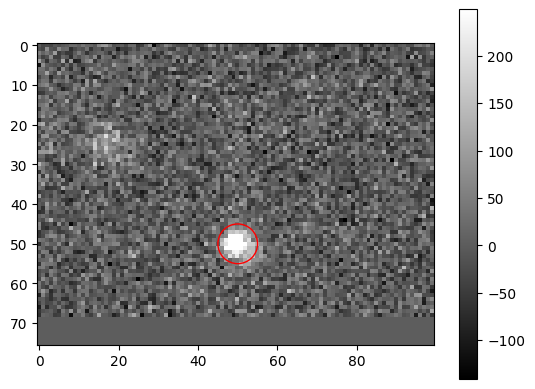

In [11]:
from astropy.visualization import ZScaleInterval

import lsst.geom as geom
import matplotlib.pyplot as plt

size = 100

full_image = butler.get(
    'calexp',
    visit=visit_id,
    detector=detector_id,
    instrument="LSSTComCam",
)
wcs = full_image.getWcs()
xy = geom.PointI(wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees)))
detector_box = full_image.getDetector().getBBox()

cutout_size = geom.ExtentI(size, size)
cutout_box = geom.BoxI(xy - cutout_size // 2, cutout_size)
cutout_box = cutout_box.clippedTo(detector_box)

cutout = butler.get(
    'calexp',
    visit=visit_id,
    detector=detector_id,
    instrument="LSSTComCam",
    parameters={
        'bbox': cutout_box,
    }
)
image_array = cutout.getImage().getArray()
# cutout.getMask()
# cutout.getVariance()
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image_array)

plt.imshow(image_array, cmap='gray', vmin=vmin, vmax=vmax)
# circle patch for source position
circle = plt.Circle(xy - cutout_box.getCorners()[0], 5, color='red', fill=False)
plt.gca().add_artist(circle)
plt.colorbar()
plt.show()